In [54]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csgraph, diags
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.metrics import (
    adjusted_rand_score, accuracy_score, precision_score, recall_score,
    f1_score, normalized_mutual_info_score, confusion_matrix
)
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.optimize import linear_sum_assignment
from kneed import KneeLocator
from scipy.stats import mode
import networkx as nx
from networkx.algorithms.community.quality import modularity
from scipy.spatial.distance import jensenshannon

from jcm import ClusterModel, run_gibbs
from jcm.utils import plot_log_likelihood, estimate_cluster

DATA_DIR = './data/'
PLOT_DIR = './plots/'

## Helper functions for plotting etc.

## Download/format the data

In [2]:
dataset = Planetoid(root=DATA_DIR, name='Cora')
data = dataset[0]
edges = data.edge_index.numpy()
class_names = {0: 'Case_Based', 1: 'Genetic_Algorithms',
              2: 'Neural_Networks', 3: 'Probabilistic_Methods',
              4: 'Reinforcement_Learning', 5: 'Rule_Learning',
              6: 'Theory'}
K = len(class_names)
W_full = sp.csr_matrix(data.x.numpy(), dtype=np.int64)
z_full = data.y.numpy()
N_full = data.num_nodes
A_full = sp.coo_matrix((np.ones(edges.shape[1]), 
                            (edges[0], edges[1])), 
                            shape=(N_full, N_full)).tocsr()

In [3]:
cmap = plt.get_cmap('Dark2', K)
colours = [cmap(i) for i in range(K)]

def visualize_embeddings(embeddings, labels, method='pca', ax=None, title=None, class_names=None):
    """Visualize node embeddings using PCA or t-SNE with discrete legend."""
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    unique_labels = np.unique(labels)
    for k in unique_labels:
        idx = labels == k
        label_name = class_names[k] if class_names else f'Class {k}'
        ax.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1],
                   c=[colours[k]], label=label_name, s=20)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    if title:
        ax.set_title(title)
    ax.legend(title="True Labels", fontsize=9, title_fontsize=10)

    if ax is None:
        plt.show()

    return reduced_embeddings


## Data exploration

### Check connectivity of the graph

In [4]:
n_components, component_labels = csgraph.connected_components(A_full, directed=False, return_labels=True)
print(f'Number of connected components: {n_components}')
print(f"Bin counts: {np.bincount(component_labels)}")

Number of connected components: 78
Bin counts: [2485    2    2    5   26    8    2    4    2    9    2    3    6    2
    2    3    2    2    2    2    2    3    2    4    4    2    3    2
    3    2    2    2    4    2    2    2    2    5    2    2    2    3
    2    2    2    2    2    2    2    2    3    4    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    5    2
    2    2    2    2    2    2    4    2]


### Discard the small disconnected components

In [5]:
largest_component_indices = component_labels == 0

A = A_full[largest_component_indices, :][:, largest_component_indices]
W = W_full[largest_component_indices]
z = z_full[largest_component_indices]
N = A.shape[0] # Number of nodes in the largest component
V = W.shape[1] # Vocabulary size

class_labels = np.unique(z)
K = len(class_labels)
class_counts = np.bincount(z)

print(f'Number of nodes in largest component = {N}')
print(f'Percentage of nodes in largest component = {N / N_full * 100:.2f}%')
print(f'Number of classes in largest component (K) = {K}')
print(f'Vocabulary size (V) = {V}')

Number of nodes in largest component = 2485
Percentage of nodes in largest component = 91.77%
Number of classes in largest component (K) = 7
Vocabulary size (V) = 1433


In [53]:
G = nx.from_scipy_sparse_array(A)

# Group nodes by their cluster label
clusters = {}
for idx, label in enumerate(z):
    clusters.setdefault(label, []).append(idx)

# Convert dict to list of node sets
communities = [set(nodes) for nodes in clusters.values()]

Q = modularity(G, communities)
print(f"Modularity: {Q:.3f}")


Modularity: 0.633


### Sparsity of graph

In [6]:
n = A.shape[0]
density = A.sum() / (n * (n - 1)) 

print(f'Density of the graph: {density:.4f}')

Density of the graph: 0.0016


### Label distribution

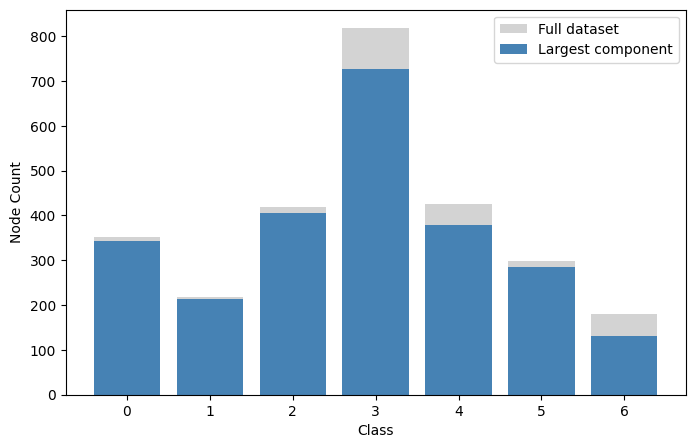

In [7]:
class_counts_full = np.bincount(z_full)
bar_width = 0.8

plt.figure(figsize=(8, 5))

# Show full dataset counts
plt.bar(class_labels, class_counts_full, color='lightgrey', label='Full dataset')

# Show largest component counts
plt.bar(class_labels, class_counts, color='steelblue', label='Largest component')

plt.xlabel('Class')
plt.ylabel('Node Count')
plt.legend()
plt.savefig(PLOT_DIR + 'class_distribution.png')
plt.show()

## Spectral embedding

### ASE - comparing full graph and largest component

#### Full graph

[14.39092445 12.36582663 11.63854942  9.72217631  9.20595631  8.6948376
  8.29052061  8.1603547   7.94659201  7.60505804  7.38269626  7.37559833
  7.30877437]


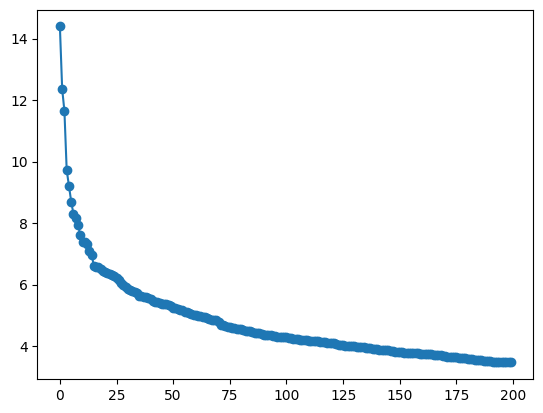

In [8]:
d_max = 200

eigvals, eigvecs = eigsh(A_full, k=d_max, which='LM')
idx = np.argsort(np.abs(eigvals))[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

plt.plot(np.abs(eigvals), marker='o')
print(np.abs(eigvals)[:13])
plt.show()


#### Just the largest component

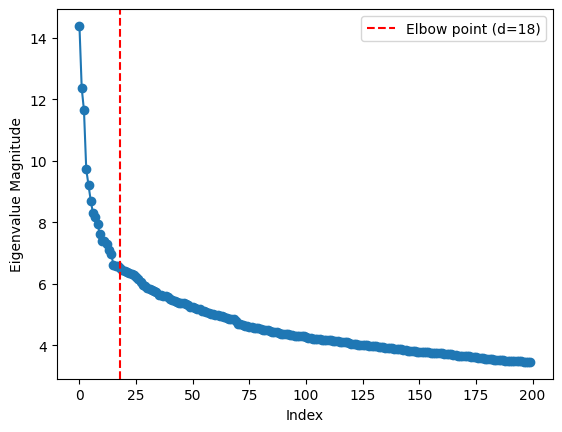

In [9]:
d_max = 200

eigvals, eigvecs = eigsh(A, k=d_max, which='LM')
idx = np.argsort(np.abs(eigvals))[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

plt.plot(np.abs(eigvals), marker='o')
d_ase = KneeLocator(range(len(eigvals)), np.abs(eigvals), curve='convex', direction='decreasing').elbow

plt.axvline(d_ase, color='red', linestyle='--', label=f'Elbow point (d={d_ase})')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Eigenvalue Magnitude')
plt.savefig(PLOT_DIR + 'scree_plot_ase.png')
plt.show()

#### Compute the ASE with chosen $d$

Adjusted Rand Index (GMM): 0.2358371508447051
Adjusted Rand Index (KMeans): 0.23369020386648737


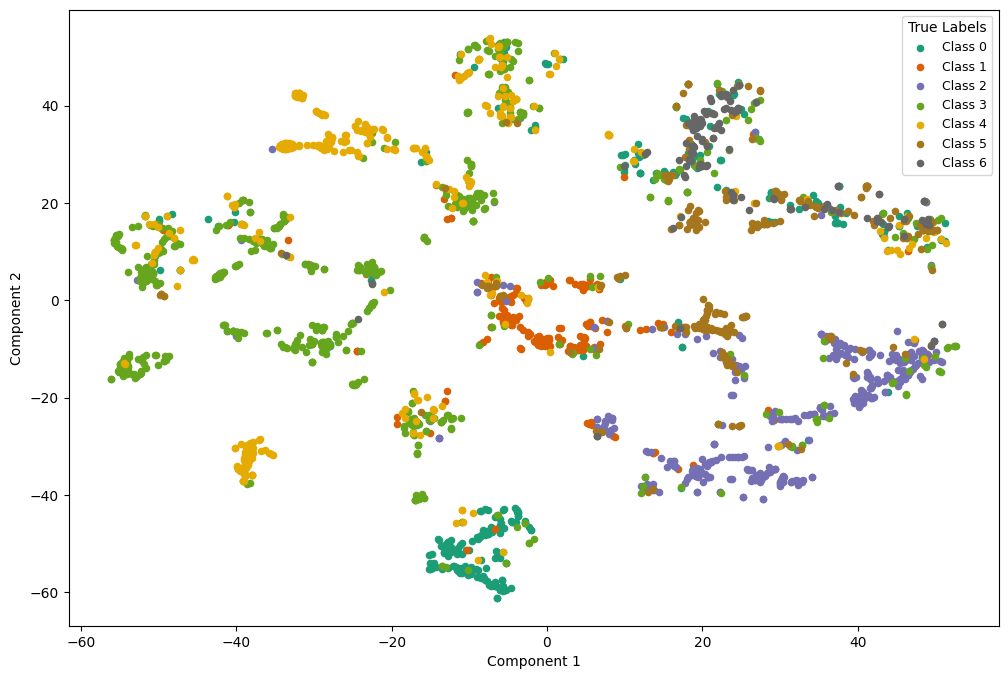

In [10]:
U = eigvecs[:, :d_ase]
Lambda_sqrt = np.diag(np.sqrt(np.abs(eigvals[:d_ase])))
X_ASE = U @ Lambda_sqrt
X_ASE = normalize(X_ASE, axis=1, norm='l2')

visualize_embeddings(X_ASE, z, method='tsne')
plt.savefig(PLOT_DIR + 'ase_tsne.png')
gmm = GaussianMixture(n_components=K, random_state=21)
gmm.fit(X_ASE)
labels_gmm = gmm.predict(X_ASE)
print(f'Adjusted Rand Index (GMM): {adjusted_rand_score(z, labels_gmm)}')

kmeans = KMeans(n_clusters=K, random_state=21, n_init='auto').fit(X_ASE)
ari = adjusted_rand_score(z, kmeans.labels_)
print(f'Adjusted Rand Index (KMeans): {ari}')

In [11]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def evaluate_clustering(X, z_true, K, n_trials=10):
    ari_kmeans, ari_gmm = [], []
    for seed in range(n_trials):
        kmeans = KMeans(n_clusters=K, random_state=seed, n_init='auto')
        gmm = GaussianMixture(n_components=K, random_state=seed)

        labels_kmeans = kmeans.fit_predict(X)
        labels_gmm = gmm.fit(X).predict(X)

        ari_kmeans.append(adjusted_rand_score(z_true, labels_kmeans))
        ari_gmm.append(adjusted_rand_score(z_true, labels_gmm))

    print(f"KMeans ARI: Median = {np.median(ari_kmeans):.3f}, Std = {np.std(ari_kmeans):.3f}")
    print(f"GMM ARI:    Median = {np.median(ari_gmm):.3f}, Std = {np.std(ari_gmm):.3f}")
    return ari_kmeans, ari_gmm

ari_kmeans, ari_gmm = evaluate_clustering(X_ASE, z, K, 50)


KMeans ARI: Median = 0.217, Std = 0.041
GMM ARI:    Median = 0.266, Std = 0.028


In [12]:
# Model hyperparameters
kappa_0 = 0.05
eta_0 = 0.05

v = np.zeros(d_ase)
for k in range(K):
    cluster_k = X_ASE[labels_gmm == k]
    if len(cluster_k) == 0:
        raise ValueError(f"Cluster {k} has no points assigned.")
    v += np.var(cluster_k, axis=0) / K

S_0 = np.diag(v)  # Shared across all clusters
m_0 = np.zeros(d_ase)  # Mean vector for the prior

# Training parameters
M = 1000 # Number of sweeps
burnin = 200

model = ClusterModel(X_ASE, W, K, labels_gmm, m_0, S_0, kappa_0=kappa_0, eta=0.05)
samples, likelihoods = run_gibbs(model, M, burnin, track_likelihood=True, show_progress=True)

Gibbs Sampling: 100%|██████████| 1200/1200 [10:44<00:00,  1.86it/s]


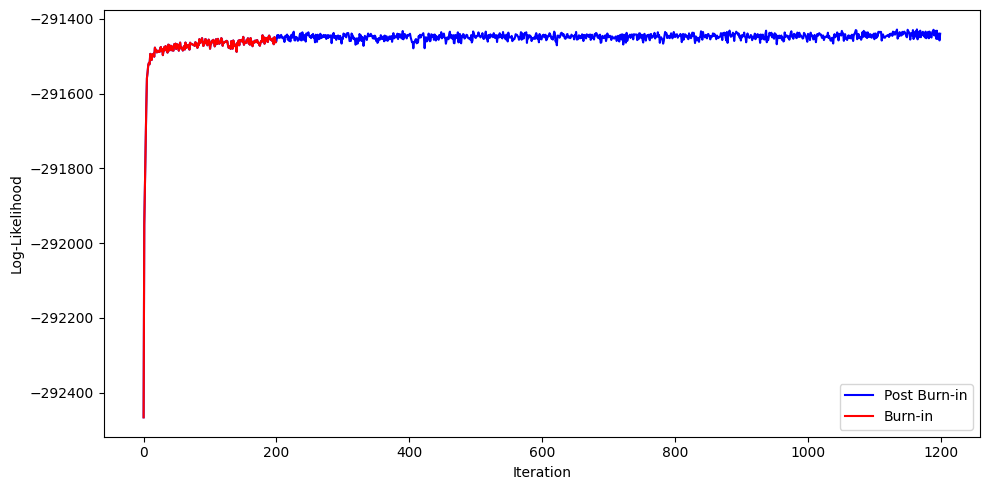

Adjusted Rand Index (psm): 0.23369020386648737
Adjusted Rand Index (mode): 0.2500304574972598


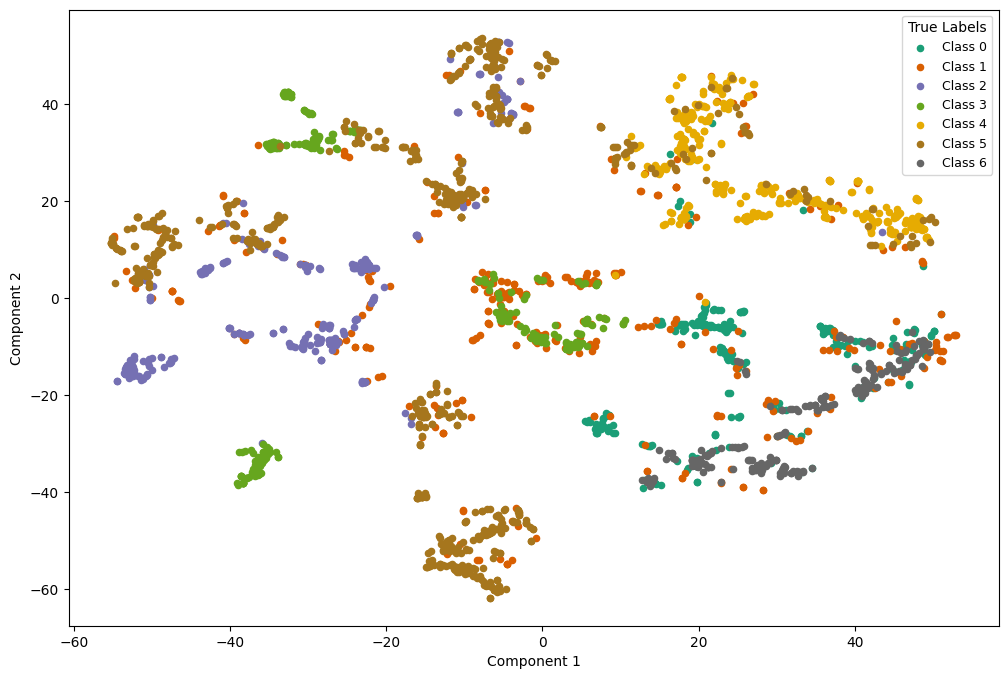

In [13]:
plot_log_likelihood(likelihoods, burnin)

z_mode = mode(samples).mode
z_psm = estimate_cluster(samples, K)
ari_psm = adjusted_rand_score(z, z_psm)
ari_mode = adjusted_rand_score(z, z_mode)
print(f'Adjusted Rand Index (psm): {ari}')
print(f'Adjusted Rand Index (mode): {ari_mode}')

X_tsne = visualize_embeddings(X_ASE, z_psm, method='tsne')

### Laplacian embedding - choosing dimensionality

In [14]:
D = A.sum(axis=1).A1
D_inv_sqrt = diags(1.0 / np.sqrt(D))
L = D_inv_sqrt @ A @ D_inv_sqrt # Normalised adjacency matrix (Laplacian in Athreya paper)

d_max = 100
# Compute smallest k_max + 1 eigenpairs of the Laplacian
eigvals, eigvecs = eigsh(L, k=d_max + 1, which='LA')

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

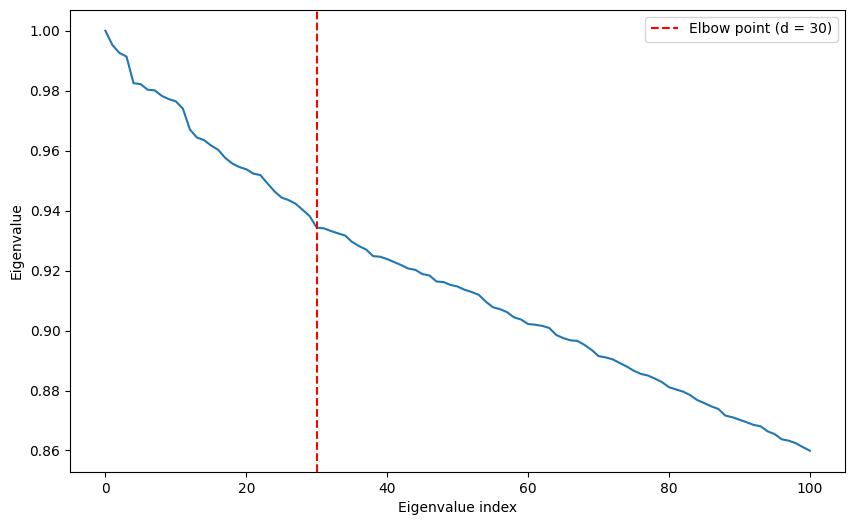

In [15]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(eigvals)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
d_lse = KneeLocator(range(len(eigvals)), eigvals, curve='convex', direction='decreasing').elbow
plt.axvline(x=d_lse, color='r', linestyle='--', label=f'Elbow point (d = {d_lse})')
plt.legend()
plt.savefig(PLOT_DIR + 'scree_plot_lse.png')
plt.show()

KMeans ARI: Median = 0.356, Std = 0.025
GMM ARI:    Median = 0.395, Std = 0.035


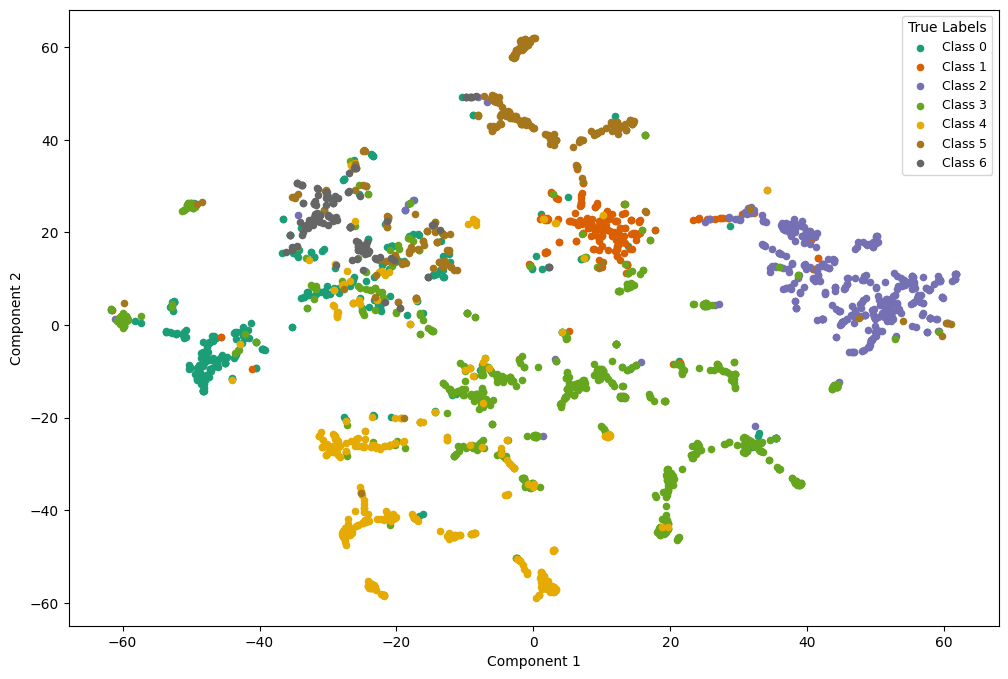

In [16]:
# Method described in Athreya et al. (2020)
U = eigvecs[:, 1:d_lse + 1]
S = np.diag(np.sqrt(eigvals[1:d_lse + 1]))
X_LSE = U @ S
X_LSE = normalize(X_LSE, axis=1)

ari_kmeans, ari_gmm = evaluate_clustering(X_LSE, z, K, 50)

X_tsne = visualize_embeddings(X_LSE, z, method='tsne') 

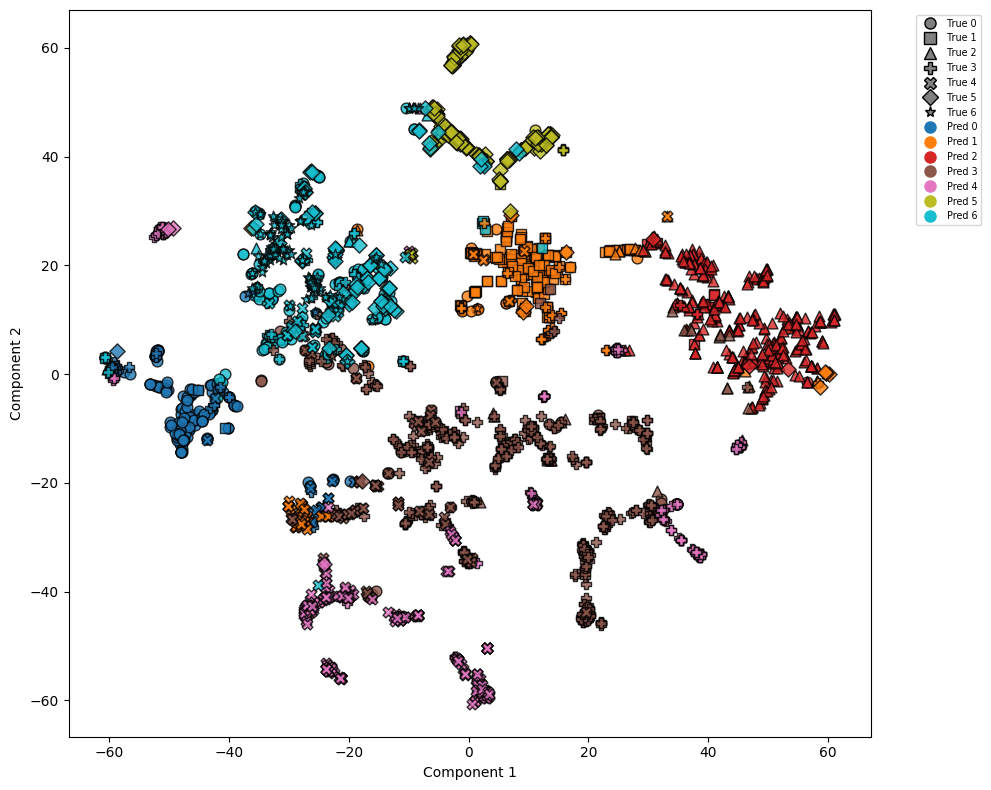

In [17]:
# Fit GMM and predict
gmm = GaussianMixture(n_components=K, random_state=21)
gmm.fit(X_LSE)
labels_gmm = gmm.predict(X_LSE)

# Hungarian matching
cm = confusion_matrix(z, labels_gmm)
row_ind, col_ind = linear_sum_assignment(-cm)
mapping = {col: row for row, col in zip(row_ind, col_ind)}
labels_pred = np.array([mapping[pred] for pred in labels_gmm])

# Project to 2D for plotting
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_LSE)

# Define shapes and colours
markers = ['o', 's', '^', 'P', 'X', 'D', '*']
cmap = plt.get_cmap('tab10', K)
colours = [cmap(i) for i in range(K)]

# Plot
plt.figure(figsize=(10, 8))
for true_label in np.unique(z):
    for pred_label in np.unique(labels_pred):
        mask = (z == true_label) & (labels_pred == pred_label)
        plt.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            c=[colours[pred_label]],
            marker=markers[true_label],
            edgecolors='k',
            label=f'True {true_label}, Pred {pred_label}',
            alpha=0.8,
            s=60
        )

# Legends
label_legend = [
    Line2D([0], [0], marker=markers[i], color='w', label=f'True {i}',
           markerfacecolor='gray', markeredgecolor='k', markersize=8)
    for i in range(K)
]
marker_legend = [
    Line2D([0], [0], marker='o', color=colours[i], label=f'Pred {i}',
           linestyle='None', markersize=8)
    for i in range(K)
]

plt.legend(
    handles=label_legend + marker_legend,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='x-small',
    title_fontsize='x-small'
)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.savefig(PLOT_DIR + 'tsne_laplacian_embeddings_aligned.png', bbox_inches='tight')
plt.show()

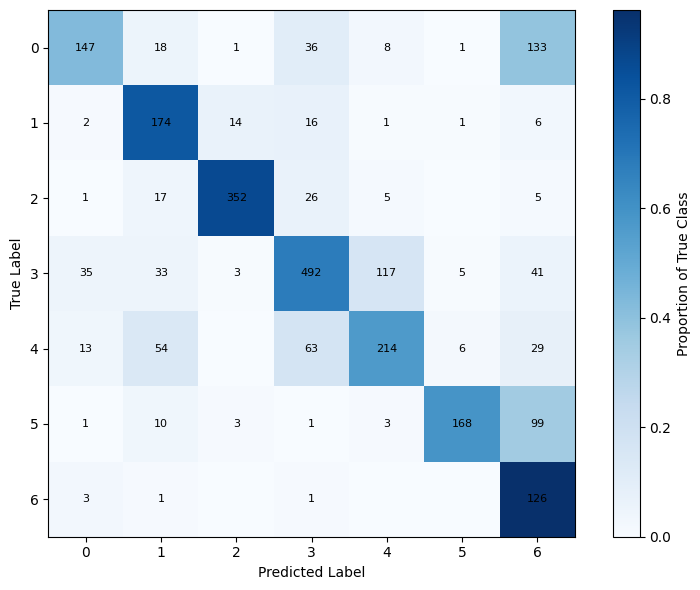

In [49]:
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MaxNLocator

# Compute confusion matrix
cm = confusion_matrix(z, labels_pred)

# Normalise by row (true class) to show proportions
cm_normalised = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalised, cmap='Blues')

# Show all ticks and label them
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text,
                ha="center", va="center",
                color="black", fontsize=8)

plt.colorbar(im, label="Proportion of True Class")
plt.tight_layout()
plt.savefig(PLOT_DIR + 'confusion_matrix.png', dpi=300)
plt.show()

In [19]:
print(f"{class_names[1]}, {class_names[6]} are the lowest accuracy clusters.")

Genetic_Algorithms, Theory are the lowest accuracy clusters.


### Run M4R model using laplacian embedding

In [20]:
v = np.zeros(d_lse)
for k in range(K):
    cluster_k = X_LSE[labels_gmm == k]
    if len(cluster_k) == 0:
        raise ValueError(f"Cluster {k} has no points assigned.")
    v += np.var(cluster_k, axis=0) / K

S_0 = np.diag(v)  # Shared across all clusters
m_0 = np.zeros(d_lse)  # Mean vector for the prior

# Other model hyperparameters
kappa_0 = 0.05

# Training parameters
n_iter = 1000
burnin = 200

model = ClusterModel(X_LSE, W, K, labels_gmm, m_0, S_0, kappa_0=kappa_0)
samples_lse, likelihoods_lse = run_gibbs(model, n_iter, burnin, track_likelihood=True)


ARI of M4R clustering using LSE embedding: 0.4228


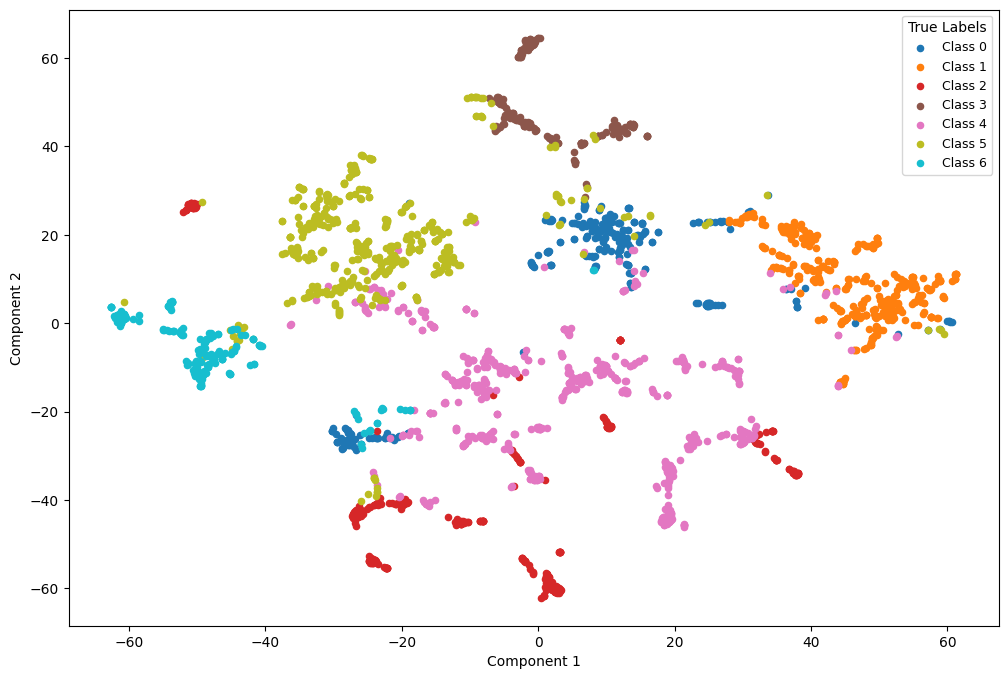

In [21]:
z_mode = mode(samples_lse, axis=0).mode
z_psm = estimate_cluster(samples_lse, K)
ari_lse = adjusted_rand_score(z, z_psm)

print(f'ARI of M4R clustering using LSE embedding: {ari_lse:.4f}')

# Visualize the clustering results
visualize_embeddings(X_LSE, z_mode, method='tsne')
plt.show()

### Fix embedding weight, vary text weight

In [22]:
M = 500
burnin = 200
weights_W = np.arange(0, 1.3, 0.05)

z_samples_W = np.zeros((len(weights_W), M, len(z)))
ari_values_W = np.zeros(len(weights_W))

for i, alpha in enumerate(weights_W):
    model = ClusterModel(X_LSE, W, K, labels_gmm, m_0, S_0, kappa_0=0.05, weight_W=alpha)
    samples, _ = run_gibbs(model, M, burnin)
    z_samples_W[i] = samples
    z_psm = estimate_cluster(samples, K)
    ari_values_W[i] = adjusted_rand_score(z, z_psm)

In [24]:
M = 500
burnin = 200
weights_X = np.arange(0, 1.3, 0.05)

z_samples_X = np.zeros((len(weights_X), M, len(z)))
ari_values_X = np.zeros(len(weights_X))

for i, alpha in enumerate(weights_X):
    model = ClusterModel(X_LSE, W, K, labels_gmm, m_0, S_0, kappa_0=0.05, weight_X=alpha)
    samples, _ = run_gibbs(model, M, burnin)
    z_samples_X[i] = samples
    z_psm = estimate_cluster(samples, K)
    ari_values_X[i] = adjusted_rand_score(z, z_psm)

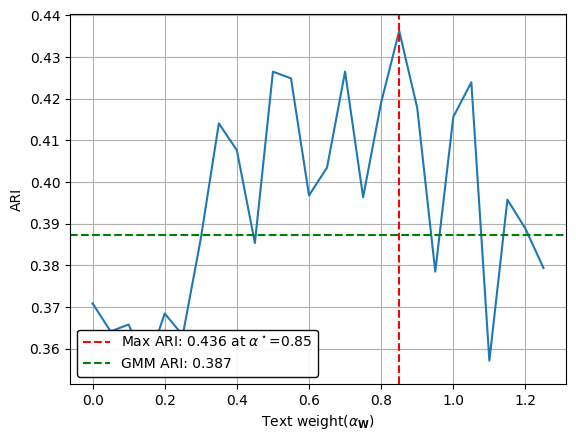

In [ ]:
plt.plot(weights_W, ari_values_W)
# Add line at maximum ARI
max_ari = np.max(ari_values_W)
max_index = np.argmax(ari_values_W)
plt.axvline(x=weights_W[max_index], color='r', linestyle='--', label=rf'Max ARI: {max_ari:.3f} at $\alpha^\star$={weights_W[max_index]:.2f}')
plt.axhline(y=np.mean(ari_gmm), color='g', linestyle='--', label=f'GMM ARI: {np.mean(ari_gmm):.3f}')
plt.legend(loc='lower left', frameon=True, framealpha=0.95, edgecolor='black')
plt.xlabel(r'Text weight($\alpha_{\mathbf{W}}$)')
plt.ylabel('ARI')
plt.grid()
plt.savefig('text_weight.png', dpi=300, bbox_inches='tight')
plt.show()

### Fix text weight, vary embedding weight

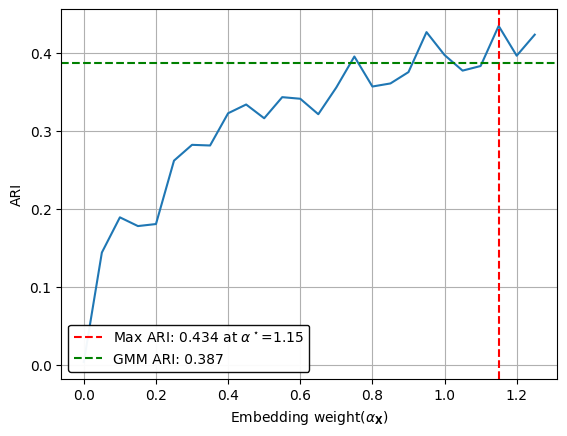

In [ ]:
plt.plot(weights_X, ari_values_X)
# Add line at maximum ARI
max_ari = np.max(ari_values_X)
max_index = np.argmax(ari_values_X)
plt.axvline(x=weights_X[max_index], color='r', linestyle='--', label=rf'Max ARI: {max_ari:.3f} at $\alpha^\star$={weights_X[max_index]:.2f}')
plt.axhline(y=np.mean(ari_gmm), color='g', linestyle='--', label=f'GMM ARI: {np.mean(ari_gmm):.3f}')
plt.legend(loc='upper left', frameon=True, framealpha=0.95, edgecolor='black')
plt.xlabel(r'Embedding weight($\alpha_{\mathbf{X}}$)')
plt.ylabel('ARI')
plt.grid()
plt.savefig('embedding_weight.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
M = 500
burnin = 200
weights_X_additional = np.arange(1.3, 2.05, 0.05)

z_samples_X_additional = np.zeros((len(weights_X_additional), M, len(z)))
ari_values_X_additional = np.zeros(len(weights_X_additional))

for i, alpha in enumerate(weights_X_additional):
    model = ClusterModel(X_LSE, W, K, labels_gmm, m_0, S_0, kappa_0=0.05, weight_X=alpha)
    samples, _ = run_gibbs(model, M, burnin)
    z_samples_X_additional[i] = samples
    z_psm = estimate_cluster(samples, K)
    ari_values_X_additional[i] = adjusted_rand_score(z, z_psm)

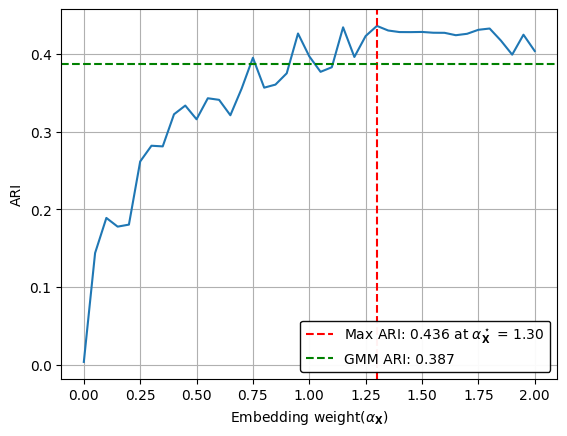

In [48]:
weights_all = np.concatenate((weights_X, weights_X_additional))
ari_all = np.concatenate((ari_values_X, ari_values_X_additional))

plt.plot(weights_all, ari_all)
# Add line at maximum ARI
max_ari = np.max(ari_all)
max_index = np.argmax(ari_all)
plt.axvline(x=weights_all[max_index], color='r', linestyle='--', label=rf"Max ARI: {max_ari:.3f} at $\alpha_{{\mathbf{{X}}}}^\star$ = {weights_all[max_index]:.2f}")
plt.axhline(y=np.mean(ari_gmm), color='g', linestyle='--', label=f'GMM ARI: {np.mean(ari_gmm):.3f}')
plt.legend(loc='lower right', frameon=True, framealpha=0.95, edgecolor='black')
plt.xlabel(r'Embedding weight($\alpha_{\mathbf{X}}$)')
plt.ylabel('ARI')
plt.grid()
plt.savefig('embedding_weight_all.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
M = 500
burnin = 200
weights_W_additional = np.arange(1.3, 2.05, 0.05)

z_samples_W_additional = np.zeros((len(weights_W_additional), M, len(z)))
ari_values_W_additional = np.zeros(len(weights_W_additional))

for i, alpha in enumerate(weights_W_additional):
    model = ClusterModel(X_LSE, W, K, labels_gmm, m_0, S_0, kappa_0=0.05, weight_W=alpha)
    samples, _ = run_gibbs(model, M, burnin)
    z_samples_W_additional[i] = samples
    z_psm = estimate_cluster(samples, K)
    ari_values_W_additional[i] = adjusted_rand_score(z, z_psm)

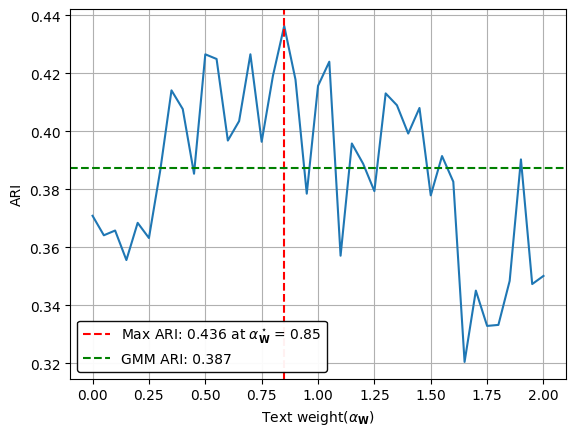

In [45]:
weights_all_W = np.concatenate((weights_W, weights_W_additional))
ari_all_W = np.concatenate((ari_values_W, ari_values_W_additional))

plt.plot(weights_all, ari_all_W)
# Add line at maximum ARI
max_ari = np.max(ari_all_W)
max_index = np.argmax(ari_all_W)
plt.axvline(x=weights_all_W[max_index], color='r', linestyle='--', label=rf"Max ARI: {max_ari:.3f} at $\alpha_{{\mathbf{{W}}}}^\star$ = {weights_all_W[max_index]:.2f}")
plt.axhline(y=np.mean(ari_gmm), color='g', linestyle='--', label=f'GMM ARI: {np.mean(ari_gmm):.3f}')
plt.legend(loc='lower left', frameon=True, framealpha=0.95, edgecolor='black')
plt.xlabel(r'Text weight($\alpha_{\mathbf{W}}$)')
plt.ylabel('ARI')
plt.grid()
plt.savefig('text_weight_all.png', dpi=300, bbox_inches='tight')
plt.show()